In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
% matplotlib inline
import cv2
import chainer
import chainer.functions as F           # パラメータを含まない関数を収録したパッケージ
import chainer.links as L               # パラメータを含む関数を収録したパッケージ
from chainer import computational_graph # グラフを出力するパッケージ
from chainer import serializers    
from chainer.datasets import tuple_dataset, TransformDataset
from chainer.training import extensions
from chainer import optimizers, serializers, training, iterators


C:\Users\falcon4842\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#読み込み
train_ = pd.read_csv('train.csv/train.csv')
test_ = pd.read_csv('test.csv/test.csv')

In [3]:
images=[]

for i in range(1, 1585):
    #%に入る
    image = cv2.imread('images2/%d.jpg'%i)
    grayed = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    images.append(grayed)

In [4]:
len(images)

1584

In [6]:
#大きさを64*64に変更する関数
def resize_image(img):
    end_size = 64
    max_ = np.maximum(img.shape[0], img.shape[1])
    scale = end_size / max_
    height, width = img.shape
    size = (int(width*scale), int(height*scale))

    rescale_image = cv2.resize(img, size, interpolation=cv2.INTER_CUBIC)

    height, width = rescale_image.shape

    if width > height:
        z_pad = np.zeros([int((width-height)/2), width], dtype=np.uint8)
        end_image = np.vstack((z_pad, rescale_image, z_pad))
    else:
        z_pad = np.zeros([height, int((height - width)/2)], dtype=np.uint8)
        end_image = np.hstack((z_pad, rescale_image, z_pad))

    end_image = cv2.resize(end_image, (end_size, end_size))

    return end_image

for i, img in enumerate(images):
    cv2.imwrite("images3/%d.jpg"%(i+1), resize_image(img))

In [7]:
#train_データのラベル
labels = train_['species']
print(len(labels))
labels.head()

990


0              Acer_Opalus
1    Pterocarya_Stenoptera
2     Quercus_Hartwissiana
3          Tilia_Tomentosa
4       Quercus_Variabilis
Name: species, dtype: object

In [8]:
#64*64の画像データをtrain_データのみリストに格納する
resized_images = []
for i in train_.id:
    image = cv2.imread('images3/%d.jpg' % i)
    grayed = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized_images.append(grayed)


In [9]:
#resized_imagesの大きさを確認
print(len(resized_images))

990


In [10]:
#numpyのarrayに変換し、chainerが扱える型にしておく
resized_images = np.array(resized_images).astype(np.float32)

In [11]:
#大きさを確認
print(resized_images.shape)

(990, 64, 64)


In [12]:
#大きさを(990, 32, 32,1 )に変換
resized_images = np.reshape(resized_images, (990, 64, 64, 1))
#大きさが変わったことを確認
print(resized_images.shape)

(990, 64, 64, 1)


In [13]:
resized_images[0].shape 

(64, 64, 1)

In [14]:
#labelのエンコードを行う。
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(labels)
labels = le.transform(labels)
labels = labels.astype(np.int32)
labels.shape

(990,)

In [15]:
#tain_の900のデータで閾値を600としてそれより前は訓練データに、後は検証データにする。訓練データと検証データをわけてから画像の水増しをするので
#leakageの心配はない
threshold = 800

In [16]:
#左右反転させるメソッド
def transform_1(images, labels,image_add_list, label_add_list):
    for img, lbl in zip(images, labels):
        x, t = img, lbl
        flipped_img = np.fliplr(x)
        #ガウシアン平滑化
        flipped_blurred = cv2.GaussianBlur(flipped_img, (11, 11), 0)
        image_add_list.append(flipped_blurred)
        label_add_list.append(t)
        
#90度回転するメソッド
def transform_2(images, labels,image_add_list, label_add_list):
    for img, lbl in zip(images, labels):
        x, t = img, lbl
        w, h, c = x.shape
        size = (w, h)
        center = (int(size[0])/2, int(size[1]/2))
        if np.random.rand() > 0.5:
            angle = 90
        else:
            angle = 180
        scale = 1.0
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)
        rotated = cv2.warpAffine(x, rotation_matrix, size)
        #ガウシアン平滑化
        rotated_blurred = cv2.GaussianBlur(rotated, (11, 11), 0)
        image_add_list.append(rotated)
        label_add_list.append(t)
        


In [17]:
#訓練データの水増しを行う。(90度度回転したもの)
image_add_train_1 = []
labels_add_train_1 = []
transform_2(resized_images[0:threshold],labels[0:threshold],image_add_train_1,labels_add_train_1)
image_add_train_1 = np.array(image_add_train_1)
labels_add_train_1 = np.array(labels_add_train_1)
image_add_train_1 = np.reshape(image_add_train_1, (800, 64, 64, 1))

print(image_add_train_1.shape)
print(labels_add_train_1.shape)

#検証(テスト)データの水増し(90度回転したもの)
image_add_test_1 = []
labels_add_test_1 = []
transform_2(resized_images[threshold:],labels[threshold:],image_add_test_1,labels_add_test_1)
image_add_test_1 = np.array(image_add_test_1).astype(np.float32)
labels_add_test_1 = np.array(labels_add_test_1).astype(np.int32)
image_add_test_1 = np.reshape(image_add_test_1, (-1, 64, 64, 1))
print(image_add_test_1.shape)
print(labels_add_test_1.shape)

(800, 64, 64, 1)
(800,)
(190, 64, 64, 1)
(190,)


In [18]:
#訓練データの水増しを行う。(左右反転したもの)
image_add_train_2 = []
labels_add_train_2 = []
transform_1(resized_images[0:threshold],labels[0:threshold],image_add_train_2,labels_add_train_2)
image_add_train_2 = np.array(image_add_train_2)
labels_add_train_2 = np.array(labels_add_train_2)
image_add_train_2 = np.reshape(image_add_train_2, (800, 64, 64, 1))

print(image_add_train_2.shape)
print(labels_add_train_2.shape)

#元の型に変える。


#検証(テスト)データの水増し(左右反転したもの)
image_add_test_2 = []
labels_add_test_2 = []
transform_1(resized_images[threshold:],labels[threshold:],image_add_test_2,labels_add_test_2)
image_add_test_2 = np.array(image_add_test_2)
labels_add_test_2 = np.array(labels_add_test_2)
image_add_test_2 = np.reshape(image_add_test_2, (-1, 64, 64, 1))
print(image_add_test_2.shape)
print(labels_add_test_2.shape)

(800, 64, 64, 1)
(800,)
(190, 64, 64, 1)
(190,)


In [19]:
#水増ししたデータを結合する。
train = np.vstack((resized_images[0:threshold], image_add_train_1, image_add_train_2))
print(train.shape)
test = np.vstack((resized_images[threshold:], image_add_test_1, image_add_test_2))
print(test.shape)

label_train = np.hstack((labels[0:threshold], labels_add_train_1,labels_add_train_2))
print(label_train.shape)
label_test = np.hstack((labels[threshold:], labels_add_test_1,labels_add_test_2))
print(label_test.shape)

(2400, 64, 64, 1)
(570, 64, 64, 1)
(2400,)
(570,)


In [20]:
#chainerが読み取れる型になおす。
train = np.reshape(train,(2400, 1, 64, 64))
test = np.reshape(test, (570, 1, 64, 64))
print(train.shape)
print(test.shape)

#標準化
train /= 255.0
test /= 255.0
train -= np.mean(train)
test -= np.mean(test)

train_data = tuple_dataset.TupleDataset(train, label_train)
test_data = tuple_dataset.TupleDataset(test, label_test)


(2400, 1, 64, 64)
(570, 1, 64, 64)


In [21]:
#4層のMLPクラスを作る。
class CNN(chainer.Chain):
    def __init__(self):
        super().__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(in_channels=1, out_channels=64, ksize=4, stride=1, pad=2)
            self.conv2 = L.Convolution2D(in_channels=64, out_channels=128, ksize=4, stride=1, pad=2)
            self.conv3 = L.Convolution2D(in_channels=None, out_channels=128, ksize=4, stride=1, pad=2) # in_channelをNoneで省略
            self.fc4 = L.Linear(None, 512)
            self.fc5 = L.Linear(None, 99) # out_channelはラベル数と同じ99に設定
        
        
    def __call__(self, X):
        h = F.relu(F.max_pooling_2d(self.conv1(X), ksize=2)) # conv1の畳み込みのあとにMaxPoolingを実行
        h = F.relu(F.max_pooling_2d(self.conv2(h), ksize=2)) # conv2の畳み込みのあとにMaxPpoolingを実行
        h = F.relu(F.max_pooling_2d(self.conv3(h), ksize=2)) # conv3の畳み込みのあとにMaxPpoolingを実行
        h = F.dropout(F.relu(self.fc4(h)), ratio=0.5) #dropout
        return self.fc5(h)


In [22]:
#model,optimizerの設定
model = L.Classifier(CNN())
optimizer = optimizers.Adam()
optimizer.setup(model)

In [23]:
batchsize = 99 #一回のバッチサイズ
n_epoch = 20 #学習の繰り返し回数

train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

In [24]:
train_iter = iterators.SerialIterator(train_data,batch_size=batchsize,shuffle=True)

updater = training.StandardUpdater(train_iter,optimizer)
trainer = training.Trainer(updater,(n_epoch,'epoch'),out = 'result')

In [25]:
test_iter = iterators.SerialIterator(test_data,batch_size=batchsize,shuffle=False,repeat=False)
trainer.extend(extensions.Evaluator(test_iter, model))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'main/loss', 'validation/main/accuracy', 'validation/main/loss']))
trainer.extend(extensions.ProgressBar())
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
                          'epoch', file_name='accuracy.png'))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))

In [26]:
trainer.run()

epoch       main/accuracy  main/loss   validation/main/accuracy  validation/main/loss
1           0.0214141      4.57015     0.0201347                 4.4962                
2           0.0736532      4.02782     0.0980471                 3.70962               
3           0.1633         3.4001      0.218788                  3.08463               
4           0.233165       2.92579     0.269226                  2.72621               
     total [##########........................................] 20.62%
this epoch [######............................................] 12.50%
       100 iter, 4 epoch / 20 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
5           0.310707       2.52984     0.338653                  2.37561               
6           0.360269       2.25267     0.349899                  2.18984               
7           0.43266        2.00707     0.400337                  2.02977               
8           0.481061       1.80075     0.433872               

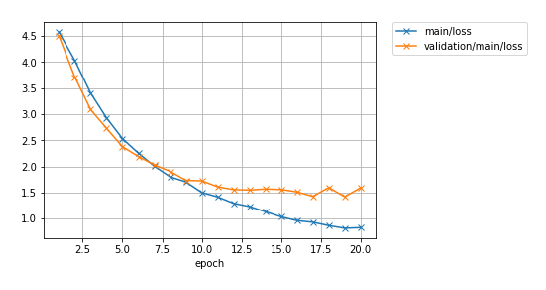

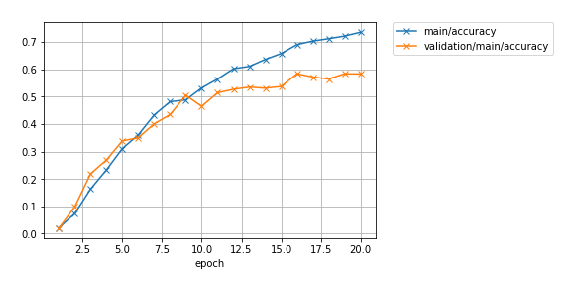

In [27]:
from pylab import box
def show_graph(src):
    img =  plt.imread(src)
    xpixels, ypixels = img.shape[0],img.shape[1]
    dpi = 100
    margin = 0.01
    figsize = (1 + margin) * ypixels / dpi, (1 + margin) * xpixels / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    ax.tick_params(labelbottom="off",bottom="off")
    ax.tick_params(labelleft="off",left="off")

    ax.imshow(img, interpolation='none')
    box("off")
    plt.show()
#損失関数と精度の視覚化    
show_graph('result/loss.png')
show_graph('result/accuracy.png')


In [28]:
#modelの保存
serializers.save_npz('leaf_classification_model', model)

In [107]:
#modelの読み込み
serializers.load_npz('leaf_classification_model', model)